In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from scipy import integrate
from scipy.stats import shapiro, levene, f_oneway
from scipy.ndimage import gaussian_filter1d
import pingouin as pg
from statsmodels.stats import oneway
from annotator_amide_abs import annotator_zoom
%matplotlib widget

In [2]:
wave_no = pd.read_csv('../mdi_optimization/cleaned_csvs/wave_no.csv')

kgy0 = pd.read_csv('../mdi_optimization/cleaned_csvs/48_scans.csv').drop(columns=['wave_no'])
kgy5 = pd.read_csv('../irradiated_analysis/5kgy/5kgy_sn48.csv')
kgy10 = pd.read_csv('../irradiated_analysis/10kgy/10kgy_sn48.csv')

for df in [kgy0, kgy5, kgy10]:
    df['average'] = df.iloc[:,:].mean(axis=1)

<h1 style="text-align: center;">Broad Amide Region Area Computation</h1>

In [3]:
wave_amide = wave_no['wave_no'].iloc[1080:1366]
amide_area_df = pd.DataFrame()

for df, group_name in zip([kgy0, kgy5, kgy10], ['0kGy_amide_area', '5kGy_amide_area', '10kGy_amide_area']):
    area_group = []
    for samp in df.columns[0:6]:
        spec_amide = df[samp][1080:1366]
        amide_area = integrate.simpson(np.flip(spec_amide), x=np.flip(wave_amide))
        area_group.append(amide_area)

    amide_area_df[group_name] = list(area_group)

In [4]:
amide_area_df

,0kGy_amide_area,5kGy_amide_area,10kGy_amide_area
0,9.564249,14.561068,13.783003
1,10.106317,13.506550,13.829999
2,9.932431,12.720796,12.916445
3,9.785493,13.985250,13.589864
4,10.373477,12.875725,14.820083
5,10.925783,12.260838,12.416946


In [5]:
kgy_amide_area = [amide_area_df[col] for col in amide_area_df.columns]

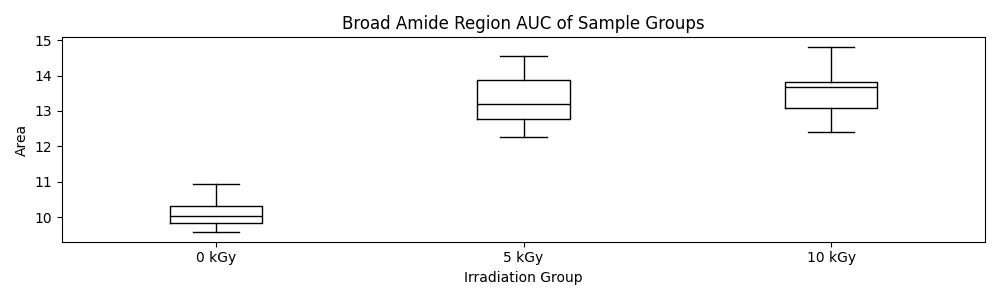

In [6]:
amide_box, axis = plt.subplots(1,1, figsize=(10,3))

axis.boxplot(x=kgy_amide_area, medianprops={'color':'black'})
axis.set(xticklabels=['0 kGy', '5 kGy', '10 kGy'],
         xlabel='Irradiation Group',
         ylabel='Area',
         title='Broad Amide Region AUC of Sample Groups')

amide_box.tight_layout()

<h1 style="text-align: center;">Statistical Analyses</h1>

In [7]:
alpha=0.05

<h2>Test for Normality (Shapiro-Wilk Test)</h2>

In [8]:
for group, area in zip(['0 kGy_amide_area', '5 kGy_amide_area', '10 kGy_amide_area'], kgy_amide_area):
    s_normal = True
    shapiro_test = shapiro(area, nan_policy='omit')
    if shapiro_test.pvalue < alpha: s_normal = False

    print(f'Group: {group} \t Normal: {s_normal} \t Statistic: {shapiro_test.statistic:.2f} \t p-Value: {shapiro_test.pvalue:.2f}')


Group: 0 kGy_amide_area 	 Normal: True 	 Statistic: 0.95 	 p-Value: 0.77
Group: 5 kGy_amide_area 	 Normal: True 	 Statistic: 0.97 	 p-Value: 0.87
Group: 10 kGy_amide_area 	 Normal: True 	 Statistic: 0.96 	 p-Value: 0.85


<h2>Test for Homogeneity of Variances (Levene's Test)</h2>

In [9]:
levene_test = levene(*kgy_amide_area, nan_policy='omit')
l_homo_var = True
if levene_test.pvalue < alpha: l_homo_var = False

print(f'Groups Analyzed: 0 kGy, 5 kGy, 10 kGy \t Homoscedasticity: {l_homo_var} \t Statistic: {levene_test.statistic:.2f} \t p-Value: {levene_test.pvalue:.2f}')


Groups Analyzed: 0 kGy, 5 kGy, 10 kGy 	 Homoscedasticity: True 	 Statistic: 0.99 	 p-Value: 0.39


<h2>Group Comparison (One-Way ANOVA)</h2>

In [10]:
f_test = f_oneway(*kgy_amide_area, nan_policy='omit')
f_sig_dif = False
if f_test.pvalue < alpha: f_sig_dif = True
print(f'Groups Compared: 0 kGy, 5 kGy, 10 kGy \t Significant Difference: {f_sig_dif} \t Statistic: {f_test.statistic:.2f} \t p-Value: {f_test.pvalue:.2E}')


Groups Compared: 0 kGy, 5 kGy, 10 kGy 	 Significant Difference: True 	 Statistic: 40.11 	 p-Value: 9.55E-07


<h2>Pairwise Comparison (Tukey's HSD Post-Hoc Test)</h2>

In [11]:
amide_area_df_long = pd.melt(amide_area_df, var_name='Dose', value_name='Broad Amide Region AUC')

In [12]:
tukey_test = pg.pairwise_tukey(data=amide_area_df_long, dv='Broad Amide Region AUC', between='Dose')
tukey_test['sig_diff'] = tukey_test['p-tukey'].apply(lambda x: 'True' if x < alpha else 'False')

In [13]:
tukey_test

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges,sig_diff
0,0kGy_amide_area,10kGy_amide_area,10.114625,13.559390,-3.444765,0.429403,-8.022228,0.000002,-4.687544,True
1,0kGy_amide_area,5kGy_amide_area,10.114625,13.318371,-3.203746,0.429403,-7.460939,0.000006,-4.239747,True
2,10kGy_amide_area,5kGy_amide_area,13.559390,13.318371,0.241019,0.429403,0.561288,0.842326,0.263516,False


<h1 style="text-align: center;">Broad Amide Region Area Visualization</h1>

In [14]:
amide_area_means = amide_area_df.mean()

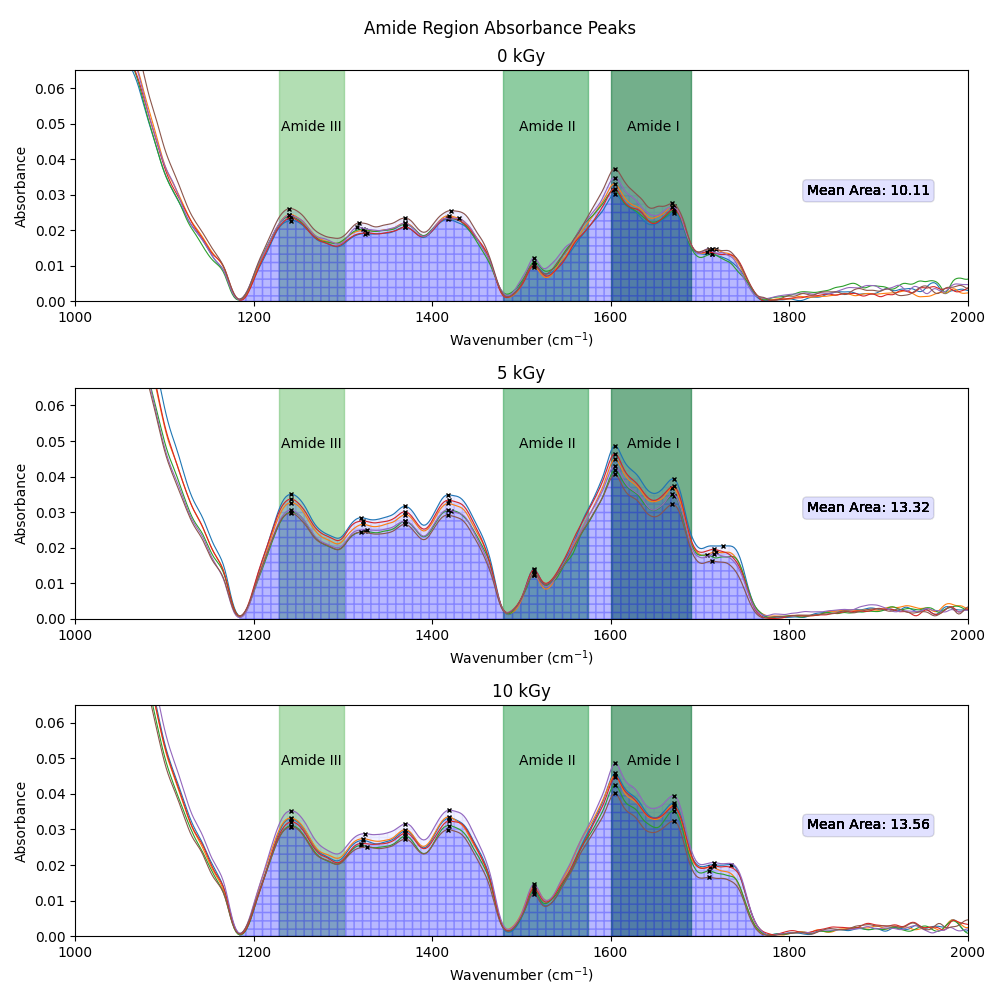

In [15]:
fig, axes = plt.subplots(3,1, figsize=(10,10))
fig.suptitle('Amide Region Absorbance Peaks')

for axis, group, mean, group_name in zip(axes, [kgy0, kgy5, kgy10], amide_area_means, ['0 kGy', '5 kGy', '10 kGy']):
    annotator_zoom(axis)

    for samp in group.columns[0:6]:
        spec = group[samp]

        sigma=2
        spec = gaussian_filter1d(spec, sigma)

        peaks, params = find_peaks(spec, distance=18)

        axis.plot(wave_no, spec, linewidth=0.8)
        axis.text(1820, 0.03, f'Mean Area: {mean:.2f}', fontsize=10, bbox=dict(facecolor='blue', alpha=0.02, boxstyle='round'))
        axis.fill_between(wave_no['wave_no'].iloc[1080:1366], spec[1080:1366], 0, color='blue', alpha=0.05, hatch='++') # Analysis region
        axis.set(title=f"{group_name}",
                 xlabel='Wavenumber (cm$^{-1}$)',
                 ylabel='Absorbance')

        for peak in peaks:
            if 1180 <= wave_no.iloc[peak,:].item() <= 1780:
                axis.plot(wave_no.iloc[peak,:], spec[peak], 'x', markersize=3.5, markeredgewidth=1, color='black')

fig.tight_layout()